<a href="https://colab.research.google.com/github/tangani/Shopee-Price-Match-Guarantee/blob/main/Shopee_Price_Match_Guarantee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Shopee - Price Match Guarantee

In [101]:
import numpy as np
import pandas as pd
import pathlib
import PIL
import PIL.Image
import matplotlib.pyplot as plt
import datetime
import cv2
import math

# import plotly.express as px

import tensorflow as tf
import tensorflow_hub as hub
print('Tensorflow version:',tf.__version__)
print('Tensorflow_hub',hub.__version__)

# Check for GPU availability
print('GPU','available(💪)' if tf.config.list_physical_devices("GPU") else "not available 😢")

Tensorflow version: 2.4.1
Tensorflow_hub 0.11.0
GPU available(💪)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Checking out the labels 

train_csv = pd.read_csv('/content/drive/MyDrive/data_science/shopee-product-matching/train.csv')
train_data = '/content/drive/MyDrive/data_science/shopee-product-matching/train_images'

test_csv = pd.read_csv('/content/drive/MyDrive/data_science/shopee-product-matching/test.csv')
test_data = '/content/drive/MyDrive/data_science/shopee-product-matching/test_images'

In [81]:
train_csv['image_path'] = train_data + '/' + train_csv.image

In [82]:
train_csv.head()

,posting_id,image,image_phash,title,label_group,image_path,target
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,/content/drive/MyDrive/data_science/shopee-pro...,"[train_129225211, train_2278313361]"
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,/content/drive/MyDrive/data_science/shopee-pro...,"[train_3386243561, train_3423213080]"
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,/content/drive/MyDrive/data_science/shopee-pro...,"[train_2288590299, train_3803689425]"
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188,/content/drive/MyDrive/data_science/shopee-pro...,"[train_2406599165, train_3342059966]"
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069,/content/drive/MyDrive/data_science/shopee-pro...,"[train_3369186413, train_921438619]"


In [6]:
train_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34250 entries, 0 to 34249
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   posting_id   34250 non-null  object
 1   image        34250 non-null  object
 2   image_phash  34250 non-null  object
 3   title        34250 non-null  object
 4   label_group  34250 non-null  int64 
 5   image_path   34250 non-null  object
dtypes: int64(1), object(5)
memory usage: 1.6+ MB


In [7]:
train_csv.isna().sum()

posting_id     0
image          0
image_phash    0
title          0
label_group    0
image_path     0
dtype: int64

## EDA

Text(0, 0.5, 'Occurences')

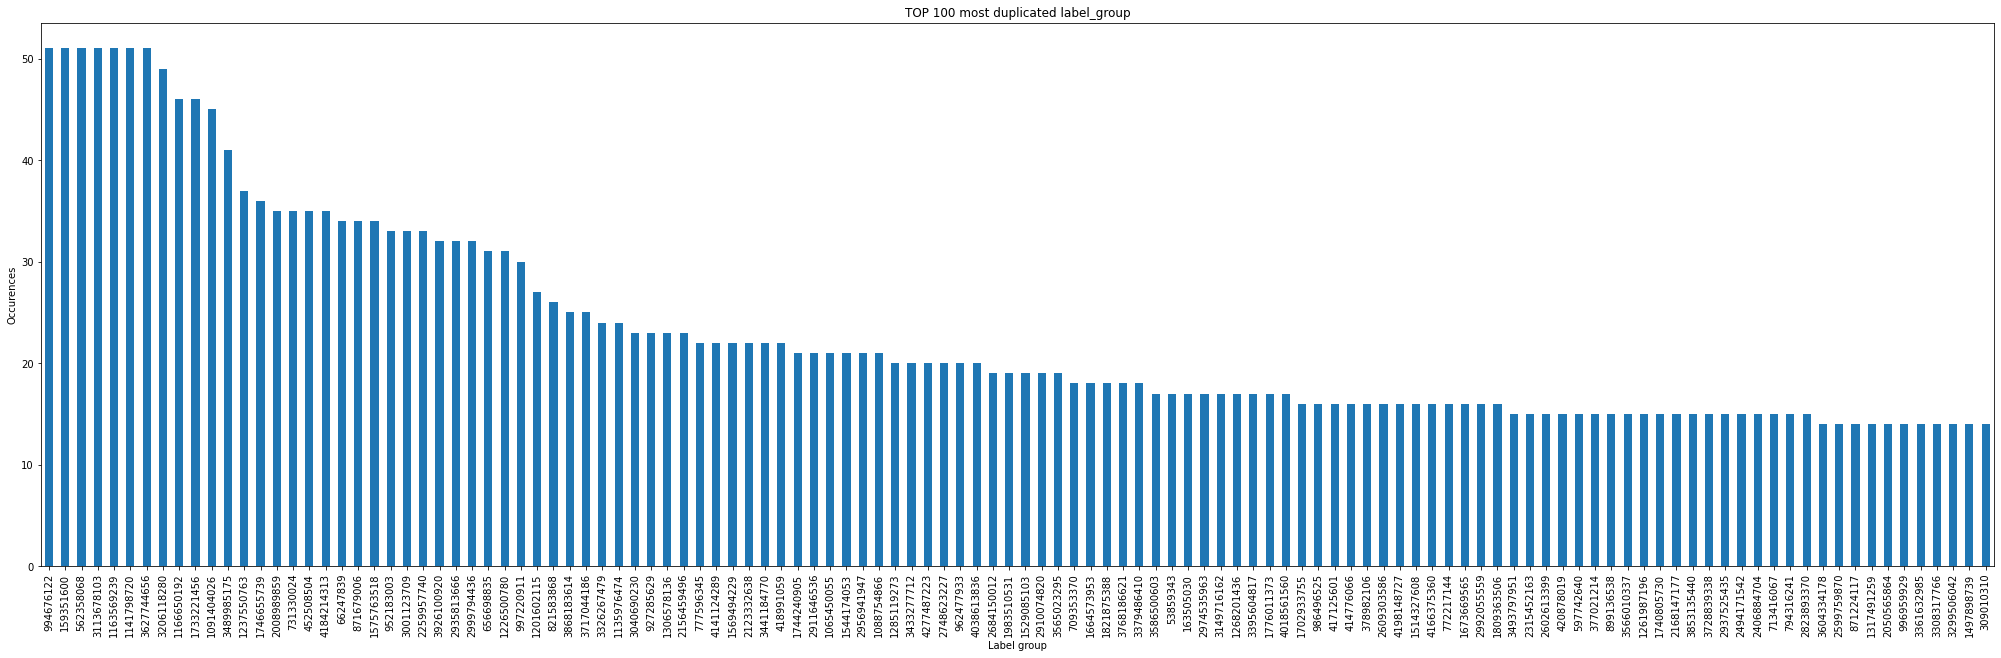

In [8]:
train_csv.label_group.value_counts().nlargest(120).plot.bar(figsize=(35,10))
plt.title("TOP 100 most duplicated label_group")
plt.xlabel("Label group")
plt.ylabel("Occurences")

In [9]:
for col in train_csv.columns:
    print(col + " : " + str(len(train_csv[col].unique())))

posting_id : 34250
image : 32412
image_phash : 28735
title : 33117
label_group : 11014
image_path : 32412


* Some images are appearing more than once
* Due to the nature of the competition, there may be duplicates in label_group, but there are also duplicates in image, image_phash, and title.

In [10]:
# Create new feature who summarize the list of posting_id associated to each label_group value. 
labelled = train_csv.groupby("label_group")["posting_id"].agg("unique")
train_csv["target"] = train_csv.label_group.map(labelled)

In [117]:
# Get random label to display pictures within the same group
random_group = train_csv.label_group.sample()
random_group.reset_index(inplace=True, drop=True)
random_label = random_group.get(key = 0)

# Get images in selecte d label group
random_label_group = train_csv.loc[train_csv['label_group'] == random_label]
random_label_group.reset_index(inplace=True, drop=True)
random_label_group

,posting_id,image,image_phash,title,label_group,image_path,target
0,train_856524373,0ff7bd904d589fccf526260e7e807dec.jpg,e1f51e4ab45e2174,Frozen detox (isi 60 kapsul),462212371,/content/drive/MyDrive/data_science/shopee-pro...,"[train_856524373, train_3807391854, train_1386..."
1,train_3807391854,2119fa1aefebfd6f9e8a989b04b5757d.jpg,80a5df0fa51bc974,Bayar Ditempat Frozen Detox Dijamin Ori,462212371,/content/drive/MyDrive/data_science/shopee-pro...,"[train_856524373, train_3807391854, train_1386..."
2,train_1386324696,5c8a14e6768c49e0bdacc316da5d94fd.jpg,a5ea9fa0602f619b,FROZEN DETOK,462212371,/content/drive/MyDrive/data_science/shopee-pro...,"[train_856524373, train_3807391854, train_1386..."
3,train_2293886082,75a7730ae5df2bf36ad96d0da990dcea.jpg,d17ae74cf3cb0841,Frozen detox,462212371,/content/drive/MyDrive/data_science/shopee-pro...,"[train_856524373, train_3807391854, train_1386..."
4,train_2579920306,7b882a85dbf51fd3fbaa27ee648d4a32.jpg,e53ad361b9855658,FROZEN D E T O C X,462212371,/content/drive/MyDrive/data_science/shopee-pro...,"[train_856524373, train_3807391854, train_1386..."
5,train_3340567571,8347d752e1d89de66915a20222c266dd.jpg,f2908d4ff2689794,FROZEN DETOX 60 KAPSUL FROZEN COLLAGEN,462212371,/content/drive/MyDrive/data_science/shopee-pro...,"[train_856524373, train_3807391854, train_1386..."
6,train_3557775099,a3e5da367ed8d5e1db6bb0c36b3f1856.jpg,80a5df0fa45bf074,Frozen Detox,462212371,/content/drive/MyDrive/data_science/shopee-pro...,"[train_856524373, train_3807391854, train_1386..."
7,train_3751059218,ccc09f971b5401e74c77daf08a993222.jpg,e53ad361b9855658,FROZEN DETOX Pelangsing Herbal Asli Original M...,462212371,/content/drive/MyDrive/data_science/shopee-pro...,"[train_856524373, train_3807391854, train_1386..."
8,train_1391076960,e5a87a5dc2e90e9b0466bfd0a8e6274a.jpg,e5cb8801630f6f9b,FROZEN DETOX MENGHILANGKAN LEMAK,462212371,/content/drive/MyDrive/data_science/shopee-pro...,"[train_856524373, train_3807391854, train_1386..."


/content/drive/MyDrive/data_science/shopee-product-matching/train_images/0ff7bd904d589fccf526260e7e807dec.jpg 0
/content/drive/MyDrive/data_science/shopee-product-matching/train_images/2119fa1aefebfd6f9e8a989b04b5757d.jpg 1
/content/drive/MyDrive/data_science/shopee-product-matching/train_images/5c8a14e6768c49e0bdacc316da5d94fd.jpg 2
/content/drive/MyDrive/data_science/shopee-product-matching/train_images/75a7730ae5df2bf36ad96d0da990dcea.jpg 3
/content/drive/MyDrive/data_science/shopee-product-matching/train_images/7b882a85dbf51fd3fbaa27ee648d4a32.jpg 4
/content/drive/MyDrive/data_science/shopee-product-matching/train_images/8347d752e1d89de66915a20222c266dd.jpg 5
/content/drive/MyDrive/data_science/shopee-product-matching/train_images/a3e5da367ed8d5e1db6bb0c36b3f1856.jpg 6
/content/drive/MyDrive/data_science/shopee-product-matching/train_images/ccc09f971b5401e74c77daf08a993222.jpg 7
/content/drive/MyDrive/data_science/shopee-product-matching/train_images/e5a87a5dc2e90e9b0466bfd0a8e6274

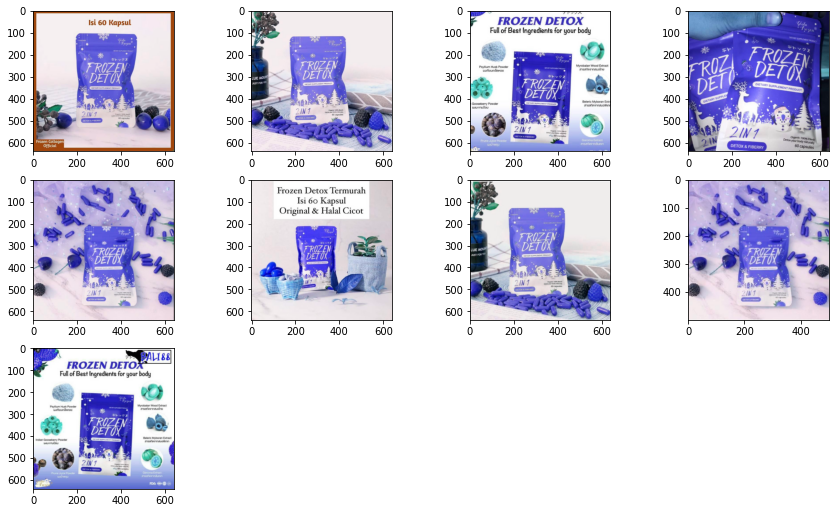

In [118]:
index = random_label_group.index.to_list()

fig = plt.figure(figsize=(30, 7))
rows = math.ceil(len(index)/2)
columns = math.ceil(len(index)//2)
fig.set_figheight(15)
fig.set_figwidth(15)
for x in range(random_label_group.shape[0]):
    print(random_label_group.image_path.get(key = x), x)
    image = cv2.imread(random_label_group.image_path.get(key = x))
    fig.add_subplot(rows, columns, x + 1)
    # print(image)
    plt.imshow(image)

* It is woth noting form the plot above that there are replocated images within the label_group but different posting_id and image name